In [0]:
#Standard Python libraries for data and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import linalg
import plotly.express as px
import json


#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from imblearn.over_sampling import SMOTE

#Import feature selection
from sklearn.feature_selection import RFE

#Import data munging tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import KFold

# Sampling methods
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

#Display charts in the notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [0]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1. Introduction

For our given task, we were trying to predict the ‘default payment for next month’, making this a binary classification problem. 

Our analysis starts by first transforming the data through means such as normalization and onehot encoding in section 3 of this notebook. Next, to get a better intuition for the dataset, we looked for linear relationships by generating a correlationheatmap between our input features and the output. It can be seen that variables such as PAY_LATE, LIMIT_BAL,PAY_DULY, PAY_AMT have high correlations while BILL_AMT has the weakest correlation with the output variable.Though simple, this analysis aided our feature selection process.

In section 4 of this notebook, we engineer two new features - CASH_FLOW and PAY_PERC, both of which aims to engineer a useful predictor from BILL_AMT, which had poor correlation with defaults. We did this by relating it to PAY_AMT, as intuitively, we expect a relationship between the total bill and payment of a customer to be indicative of whether or not a customer would default. CASH_FLOW does this by subtracting amount paid from the bill, henace measuring the monthly debt amount of each customer. PAY_PERC takes the log of BILL_AMT/PAY_AMT, hence measuring how much bigger in magnitude a customer's bill is compared to hom much they're willing to pay. With the latter being a non-linear transformation of BILL_AMT, we believe this will act as a better predictor feature.

In section 5, we define functions for cross-validation and visualisations which will be used for model selection and feature selection in the following section.

In section 6, we detail the training results of the different models. Using k-fold cross-validation, we find that logistic regression with undersampling provides thebest F1 Score for defaults (the minority class), with a score of 0.525. We then performed RFE on this model, which allowed us to improve the F1 Score to 0.531, and allowed us to determine which were the most important features in the dataset for our given model (with 34 features being selected).

In section 7, we ran our model on the test set, which gave us an overall accuracy of 0.79, and a F1 Score of 0.54 fordefaults. We obtained slightly better metrics on the test set than on the training set. Overall, our approach to model selection and feature selection, as well as the newly engineered PAY_PERC feature, provided the best result we could find for maximising performance for default prediction.

# 2. Data Import


Imports csv data into Pandas DataFrame, where ``` train_data ``` is the training dataset and ``` test_data ``` is the testing dataset. All numerical-valued columns (see first cell's 'numerical columns') are casted to ``` int ```.

For consistency's sake, ``` PAY_0 ``` column has been renamed to ``` PAY_1 ``` which is absent in the dataset.



In [0]:
orig_columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

numerical_columns = ['LIMIT_BAL', 'AGE','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE']

y_str = 'default payment next month'

pay_columns = ['PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

bill_amt = ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

pay_amt = ['PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [0]:
train_url = 'https://raw.githubusercontent.com/wiryawanm/CreditCard_Data/master/CreditCard_train.csv'

train_data = pd.read_csv(train_url)
train_data.columns = train_data.iloc[0]
train_data.drop(0,axis=0,inplace=True)
train_data = train_data.set_index('ID')
train_data = train_data.rename({'PAY_0':'PAY_1'},axis=1)


test_url = 'https://raw.githubusercontent.com/wiryawanm/CreditCard_Data/master/CreditCard_test.csv'

test_data = pd.read_csv(test_url)
test_data.columns = test_data.iloc[0]
test_data.drop(0,axis=0,inplace=True)
test_data = test_data.set_index('ID')
test_data = test_data.rename({'PAY_0':'PAY_1'},axis=1)

for column in numerical_columns+[y_str]:
    train_data[column] = train_data[column].astype(int)
    test_data[column] = test_data[column].astype(int)

# 3. Data Transformation & Exploration

Code for the equivalent section in your report, together with in-line
that code.

## Transformation: One-Hot Encoding

Three columns, 'SEX', 'EDUCATION', and 'MARRIAGE', are to be one-hot encoded to ensure that they act as nomical categorical values. The result on this encoding are a modified training and testing dataframe (``` ohe_train_data ``` and ``` ohe_test_data ``` respectively), which drops the categorical columns and adds their encodings.

Before each feature is one-hot encoded, categorical values undefined in the documentation is casted to an "Others" category as appropriate.

After one-hot encoding, one class-value column is dropped to avoid the "dummy variable trap".

In [0]:
print('== Categories Before modification == ')
print('SEX categories: ' + str(train_data['SEX'].unique()))
print('MARRIAGE categories: ' + str(train_data['MARRIAGE'].unique()))
print('EDUCATION categories: ' + str(train_data['EDUCATION'].unique()))

train_data.loc[train_data['MARRIAGE'].astype(int) == 0, 'MARRIAGE'] = '3'
train_data.loc[train_data['EDUCATION'].astype(int)>4, 'EDUCATION'] = '4'
train_data.loc[train_data['EDUCATION'].astype(int) == 0, 'EDUCATION'] = '4'

test_data.loc[test_data['MARRIAGE'].astype(int) == 0, 'MARRIAGE'] = '3'
test_data.loc[test_data['EDUCATION'].astype(int)>4, 'EDUCATION'] = '4'
test_data.loc[test_data['EDUCATION'].astype(int) == 0, 'EDUCATION'] = '4'

print('\n== Categories after modification == ')
print('SEX categories: ' + str(train_data['SEX'].unique()))
print('MARRIAGE categories: ' + str(train_data['MARRIAGE'].unique()))
print('EDUCATION categories: ' + str(train_data['EDUCATION'].unique()))

== Categories Before modification == 
SEX categories: ['2' '1']
MARRIAGE categories: ['1' '2' '3' '0']
EDUCATION categories: ['2' '1' '3' '5' '4' '6' '0']

== Categories after modification == 
SEX categories: ['2' '1']
MARRIAGE categories: ['1' '2' '3']
EDUCATION categories: ['2' '1' '3' '4']


In [0]:
ohe_dataframes =[]
for column in categorical_columns:
    oh_features = pd.get_dummies(train_data[column].astype(str))
    oh_features.rename(columns={col: column + ' ' + col for col in oh_features.columns},inplace=True)
    oh_features.drop(oh_features.columns[-1],axis=1,inplace=True)
    ohe_dataframes.append(oh_features)

train_data = pd.concat([train_data.drop(categorical_columns,axis=1)] + ohe_dataframes, axis=1)


ohe_dataframes =[]
for column in categorical_columns:
    oh_features = pd.get_dummies(test_data[column].astype(str))
    oh_features.rename(columns={col: column + ' ' + col for col in oh_features.columns},inplace=True)
    oh_features.drop(oh_features.columns[-1],axis=1,inplace=True)
    ohe_dataframes.append(oh_features)

test_data = pd.concat([test_data.drop(categorical_columns,axis=1)] + ohe_dataframes, axis=1)

# column names as list for later access
marriages = ['MARRIAGE ' + str(i) for i in range(1,3)]
educations = ['EDUCATION ' + str(i) for i in range(1,4)]
sexes = ['SEX ' + str(i) for i in range(1,2)]

test_data.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
       'SEX 1', 'EDUCATION 1', 'EDUCATION 2', 'EDUCATION 3', 'MARRIAGE 1',
       'MARRIAGE 2'],
      dtype='object')

## Transformation: Modifying payment status features

```PAY[1-6]``` was modified to three separate columns, as it contains both categorical and numerical information. We create the following features and dropped ```PAY[1-6]```.

-       PAY_LATE_x : (binary) indicates if payment is late (1 if PAY_x >0, and 0 otherwise).
-       PAY_LATE_MONTHS_x : (int) indicates the number of months late, if PAY_LATE_x = 1.
-       PAY_DULY_x : (binary) indicates if payment is made fully (1 if PAY_x  = -1, and 0 otherwise).

In [0]:
for i in range(1,7):
    train_data['PAY_LATE_'+str(i)] = (train_data['PAY_'+str(i)].astype(int) > 0).astype(np.uint8)
    train_data['PAY_LATE_MONTHS_'+str(i)] = (train_data['PAY_'+str(i)].astype(int) > 0).astype(int) * train_data['PAY_'+str(i)].astype(int)
    train_data['PAY_DULY_'+str(i)] = (train_data['PAY_'+str(i)].astype(int) < 0).astype(np.uint8)
    train_data.drop('PAY_'+str(i),inplace=True,axis=1)

for i in range(1,7):
    test_data['PAY_LATE_'+str(i)] = (test_data['PAY_'+str(i)].astype(int) > 0).astype(np.uint8)
    test_data['PAY_LATE_MONTHS_'+str(i)] = (test_data['PAY_'+str(i)].astype(int) > 0).astype(int) * test_data['PAY_'+str(i)].astype(int)
    test_data['PAY_DULY_'+str(i)] = (test_data['PAY_'+str(i)].astype(int) < 0).astype(np.uint8)
    test_data.drop('PAY_'+str(i),inplace=True,axis=1)
    

paylate = ['PAY_LATE_' + str(i) for i in range(1,7)]
paylatemonths = ['PAY_LATE_MONTHS_' + str(i) for i in range(1,7)]
payduly = ['PAY_DULY_' + str(i) for i in range(1,7)]

train_data.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
       'SEX 1', 'EDUCATION 1', 'EDUCATION 2', 'EDUCATION 3', 'MARRIAGE 1',
       'MARRIAGE 2', 'PAY_LATE_1', 'PAY_LATE_MONTHS_1', 'PAY_DULY_1',
       'PAY_LATE_2', 'PAY_LATE_MONTHS_2', 'PAY_DULY_2', 'PAY_LATE_3',
       'PAY_LATE_MONTHS_3', 'PAY_DULY_3', 'PAY_LATE_4', 'PAY_LATE_MONTHS_4',
       'PAY_DULY_4', 'PAY_LATE_5', 'PAY_LATE_MONTHS_5', 'PAY_DULY_5',
       'PAY_LATE_6', 'PAY_LATE_MONTHS_6', 'PAY_DULY_6'],
      dtype='object')

## Exploration: Correlation Analysis

We conducted a basic correlation analysis to evaluate the linear significance of each input feature to the output feature. Correlation heatmap is separated into three graphs as to prevent matrices from being cluttered. 

Only the final matrix, which includes various breakdowns of ```PAY[1-6]```, is included in the report as they have the highest correlation with defaults. The correlation scores of all features with defaults is presented in the last cell.

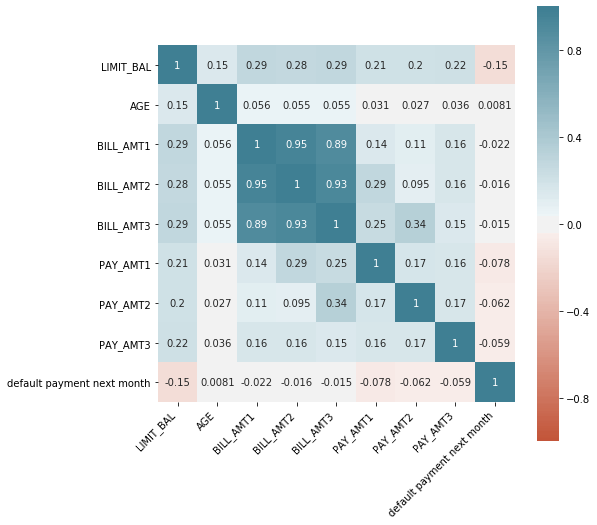

In [0]:
plt.subplots(figsize=(8,8))

corr = train_data[['LIMIT_BAL','AGE']+ bill_amt[0:3]+ pay_amt[0:3]+[y_str]].astype(float).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

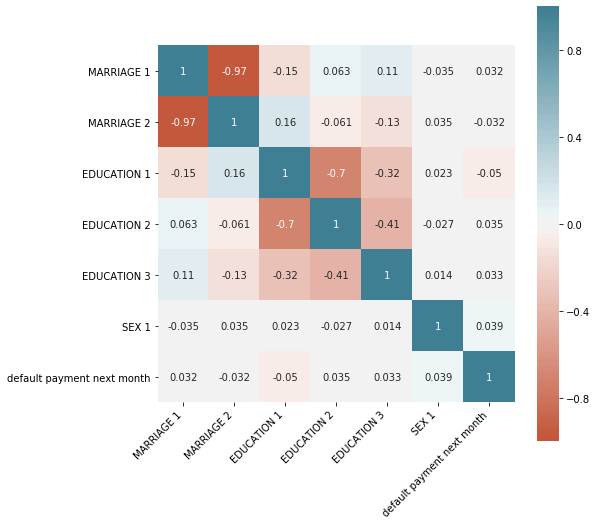

In [0]:
plt.subplots(figsize=(8,8))

corr = train_data[marriages+educations+sexes+[y_str]].astype(float).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

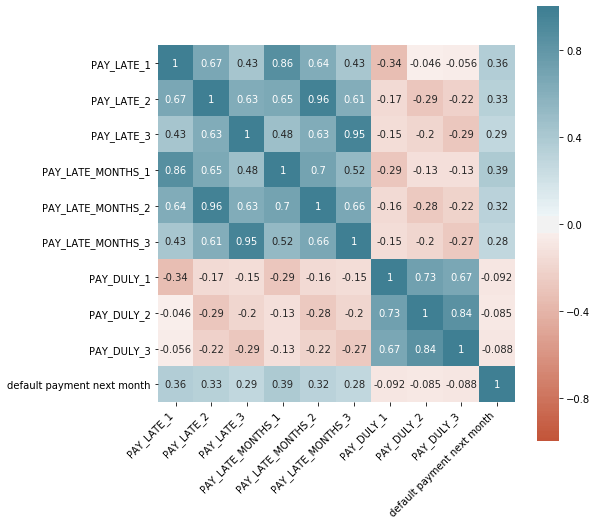

In [0]:
plt.subplots(figsize=(8,8))

corr = train_data[paylate[0:3]+paylatemonths[0:3]+payduly[0:3]+[y_str]].astype(float).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig('pay_corr.png')

In [0]:
corr = train_data.astype(float).corr()
corr['abs_corr'] = corr[y_str].abs()
corr.sort_values('abs_corr',axis=0,ascending=False)[y_str]

default payment next month    1.000000
PAY_LATE_MONTHS_1             0.391847
PAY_LATE_1                    0.364739
PAY_LATE_2                    0.333862
PAY_LATE_MONTHS_2             0.323103
PAY_LATE_3                    0.288354
PAY_LATE_MONTHS_3             0.281859
PAY_LATE_4                    0.269458
PAY_LATE_5                    0.266445
PAY_LATE_MONTHS_4             0.262582
PAY_LATE_MONTHS_5             0.260037
PAY_LATE_6                    0.240683
PAY_LATE_MONTHS_6             0.240026
LIMIT_BAL                    -0.148726
PAY_DULY_1                   -0.092354
PAY_DULY_3                   -0.088149
PAY_DULY_2                   -0.084887
PAY_DULY_4                   -0.078183
PAY_AMT1                     -0.077859
PAY_DULY_5                   -0.075011
PAY_DULY_6                   -0.067832
PAY_AMT2                     -0.061610
PAY_AMT3                     -0.058935
PAY_AMT4                     -0.058059
PAY_AMT6                     -0.056756
PAY_AMT5                 

## Exploration: Principal Components Analysis

Principal Component Analysis (PCA) was applied on continuous numerical features ```PAY_LATE_MONTHS```, ```PAY_AMT```, ```BILL_AMT```, and ```LIMIT_BAL```, where the first and second principal components were visualised with a scatter plot.


Text(0.5, 0, '')

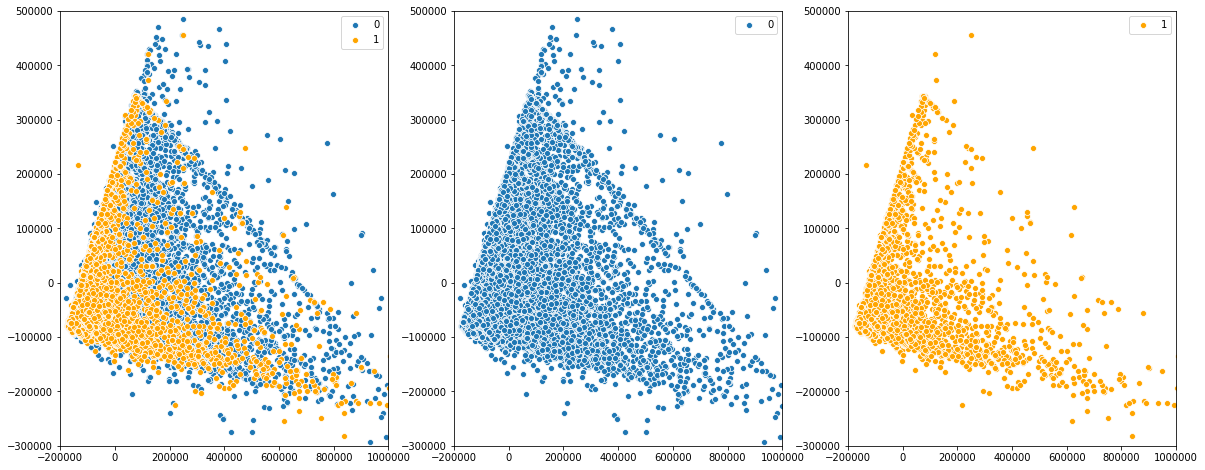

In [0]:
pca_train_data = train_data.copy()
pca_factor = PCA(n_components=2).fit_transform(pca_train_data[pay_amt+paylatemonths+['LIMIT_BAL']+bill_amt]).transpose()
pca_train_data['pca0'] = pca_factor[0]
pca_train_data['pca1'] = pca_factor[1]
fig,axs = plt.subplots(1,3)
fig.set_figheight(8)
fig.set_figwidth(20)

# sns.scatterplot(pca_train_data['pca0'],pca_train_data['pca1'],pca_train_data[y_str],size=5,edgecolors="black",legend=False,ax=axs[0])
sns.scatterplot(pca_train_data[pca_train_data[y_str]==0]['pca0'],pca_train_data[pca_train_data[y_str]==0]['pca1'],ax=axs[1])
sns.scatterplot(pca_train_data[pca_train_data[y_str]==1]['pca0'],pca_train_data[pca_train_data[y_str]==1]['pca1'],ax=axs[2],color="orange")
sns.scatterplot(pca_train_data[pca_train_data[y_str]==0]['pca0'],pca_train_data[pca_train_data[y_str]==0]['pca1'],ax=axs[0])
sns.scatterplot(pca_train_data[pca_train_data[y_str]==1]['pca0'],pca_train_data[pca_train_data[y_str]==1]['pca1'],ax=axs[0],color="orange")


axs[0].set_xlim([-200000,1000000])
axs[0].set_ylim([-300000,500000])
axs[0].legend(['0','1'],loc='upper right')
axs[0].set_ylabel('')    
axs[0].set_xlabel('')

axs[1].set_xlim([-200000,1000000])
axs[1].set_ylim([-300000,500000])
axs[1].legend(['0'],loc='upper right')
axs[1].set_ylabel('')    
axs[1].set_xlabel('')

axs[2].set_xlim([-200000,1000000])
axs[2].set_ylim([-300000,500000])
axs[2].legend(['1'],loc='upper right')
axs[2].set_ylabel('')    
axs[2].set_xlabel('')


## Exploration: Trends of LIMIT_BAL and AGE (Extra)

We plotted two distribution graphs to understand the varying ditributions of two singular numerical variables, LIMIT_BAL and AGE. This visualisation was ultimately excluded from the report, as we were unable to obtain significant benefit from it throughout our investigation, as the trend of both features for defaulters and non-defaulters are similar.


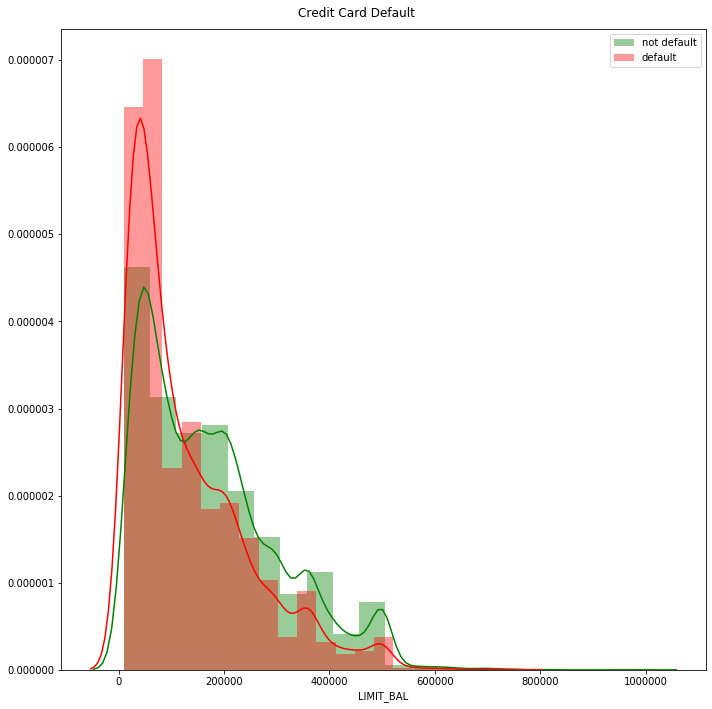

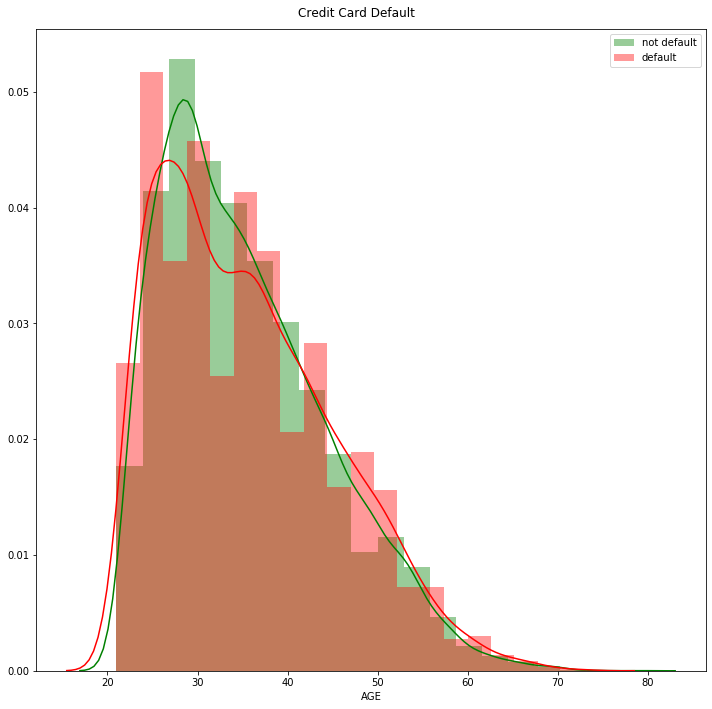

In [31]:
fig = plt.figure(figsize = (10, 10))
sns.distplot(train_data['LIMIT_BAL'][train_data[y_str]==0], color='g', label = 'not default',bins=20)
sns.distplot(train_data['LIMIT_BAL'][train_data[y_str]==1], color='r', label = 'default',bins=20)
plt.legend(loc='best')
fig.suptitle('Credit Card Default')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

fig = plt.figure(figsize = (10, 10))
sns.distplot(train_data['AGE'][train_data[y_str]==0], color='g', label = 'not default',bins=20)
sns.distplot(train_data['AGE'][train_data[y_str]==1], color='r', label = 'default',bins=20)
plt.legend(loc='best')
fig.suptitle('Credit Card Default')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

# 4. Methodology Overview

Here, we conduct feature engineering to create two new set of features using ```PAY_AMT[1-6]``` and ```BILL_AMT[1-6]```. Due to the one month offset between the two columns (as described in our data exploration section), we only have five valid sets  of payment amount / bill amount pairings. These engineered features are:

- ```CASH_FLOW[1-5]``` : subtracting ```PAY_AMT[x]``` from ```BILL_AMT[x+1]```, hence resulting in a "cash flow" attribute of each customer every month. This is with the expectation that defaulters will have a tendency to have high positive cash flow in recent months.

- ```PAY_PERC[1-5]``` : taking the log of the division of ```BILL_AMT[x+1]``` by ```PAY_AMT[x]```, hence measuring how much bigger (in magnitude) the bill amount is compared to the payment made for that bill. This is with the expectation that defaulters willk have a significantly larger bill amount than payment made in months leading to their default.

Repeating the correlation analysis, it can be seen that ```PAY_PERC``` achieves much higher correlation compared to their corresponding ```PAY_AMT``` and ```BILL_AMT```.

In [0]:
for i in range(1,6):
    train_data['PAY_PERC_'+str(i)] = np.log(train_data['PAY_AMT'+str(i)]/train_data['BILL_AMT'+str(i+1)])
    test_data['PAY_PERC_'+str(i)] = np.log(test_data['PAY_AMT'+str(i)]/test_data['BILL_AMT'+str(i+1)])

for i in range(1,6):
    train_data['CASH_FLOW_'+str(i)] = train_data['BILL_AMT'+str(i+1)] - train_data['PAY_AMT'+str(i)]
    test_data['CASH_FLOW_'+str(i)] = test_data['BILL_AMT'+str(i+1)] - test_data['PAY_AMT'+str(i)]

pay_percentage = ['PAY_PERC_'+str(i) for i in range(1,6)]
cash_flow = ['CASH_FLOW_'+str(i) for i in range(1,6)]

train_data = train_data.replace([np.inf],np.nan)
train_data[pay_percentage] = train_data[pay_percentage].fillna(1.0)
train_data = train_data.replace([-np.inf],-12)

test_data = test_data.replace([np.inf],np.nan)
test_data[pay_percentage] = test_data[pay_percentage].fillna(1.0)
test_data = test_data.replace([-np.inf],-12)

train_data.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
       'SEX 1', 'EDUCATION 1', 'EDUCATION 2', 'EDUCATION 3', 'MARRIAGE 1',
       'MARRIAGE 2', 'PAY_LATE_1', 'PAY_LATE_MONTHS_1', 'PAY_DULY_1',
       'PAY_LATE_2', 'PAY_LATE_MONTHS_2', 'PAY_DULY_2', 'PAY_LATE_3',
       'PAY_LATE_MONTHS_3', 'PAY_DULY_3', 'PAY_LATE_4', 'PAY_LATE_MONTHS_4',
       'PAY_DULY_4', 'PAY_LATE_5', 'PAY_LATE_MONTHS_5', 'PAY_DULY_5',
       'PAY_LATE_6', 'PAY_LATE_MONTHS_6', 'PAY_DULY_6', 'PAY_PERC_1',
       'PAY_PERC_2', 'PAY_PERC_3', 'PAY_PERC_4', 'PAY_PERC_5', 'CASH_FLOW_1',
       'CASH_FLOW_2', 'CASH_FLOW_3', 'CASH_FLOW_4', 'CASH_FLOW_5'],
      dtype='object')

In [0]:
corr = train_data.astype(float).corr()
corr['abs_corr'] = corr[y_str].abs()
corr.sort_values('abs_corr',axis=0,ascending=False)[y_str]

default payment next month    1.000000
PAY_LATE_MONTHS_1             0.391847
PAY_LATE_1                    0.364739
PAY_LATE_2                    0.333862
PAY_LATE_MONTHS_2             0.323103
PAY_LATE_3                    0.288354
PAY_LATE_MONTHS_3             0.281859
PAY_LATE_4                    0.269458
PAY_LATE_5                    0.266445
PAY_LATE_MONTHS_4             0.262582
PAY_LATE_MONTHS_5             0.260037
PAY_LATE_6                    0.240683
PAY_LATE_MONTHS_6             0.240026
PAY_PERC_1                   -0.182456
PAY_PERC_2                   -0.160924
LIMIT_BAL                    -0.148726
PAY_PERC_3                   -0.146775
PAY_PERC_4                   -0.135264
PAY_PERC_5                   -0.124029
PAY_DULY_1                   -0.092354
PAY_DULY_3                   -0.088149
PAY_DULY_2                   -0.084887
PAY_DULY_4                   -0.078183
PAY_AMT1                     -0.077859
PAY_DULY_5                   -0.075011
PAY_DULY_6               

# 5. Model Training & Validation

In this section we define our k-fold cross validation function and graphing function which is used to evaluate and compare our models. We also initialize five different models which we will compare in the following section.

In [0]:
# Iteratively add dictionary values (subjected to multiplier for averaging)
def sum_dicts(dict1,dict2,mult=1):
    if(type(dict1)!=type({}) and type(dict2)!=type({})):
        return dict1 + dict2*mult
    else:
        return { k: sum_dicts(dict1.get(k, 0),dict2.get(k, 0),mult) for k in set(dict1) | set(dict2) }
    
    
# Print average k-fold classification report
def k_fold_test(training_data, model, y_feature,X_features=None, k=10, 
                scaler=StandardScaler(),scale_data=True,
                sampler = None):
    
    kf = KFold(n_splits=k,random_state=420,shuffle=True)
    
    X = training_data.drop(y_feature,axis=1,inplace=False)
#     if X_features != None:
    X = training_data[X_features]
    y = training_data[y_feature]
    
    total_report = {
         '1': {'recall': 0, 
              'support': 0, 
              'precision': 0, 
              'f1-score': 0,
              'bin count': 0},  
        
        '0': {'recall': 0, 
              'support': 0, 
              'precision': 0, 
              'f1-score': 0,
              'bin count': 0},  

        'macro avg': {'recall': 0, 
                      'support': 0, 
                      'precision': 0, 
                      'f1-score': 0,
                      'bin count': 0},
        
        'weighted avg': {'recall': 0, 
                         'support': 0, 
                         'precision': 0, 
                         'f1-score': 0,
                         'bin count': 0}, 

        'accuracy': 0
    }

    for index_train, index_test in kf.split(training_data):
        X_valid_train, X_valid_test = X.iloc[index_train], X.iloc[index_test]
        y_valid_train, y_valid_test = y.iloc[index_train], y.iloc[index_test]
               
        if scale_data:
            X_valid_train = scaler.fit_transform(X_valid_train)
            X_valid_test = scaler.transform(X_valid_test)
        
        if sampler != None:
            X_valid_train, y_valid_train = sampler.fit_resample(X_valid_train, y_valid_train)

        model.fit(X_valid_train,y_valid_train)
        
        y_pred = model.predict(X_valid_test)
        
        report = metrics.classification_report(y_valid_test,y_pred,output_dict=True)
        bc = np.bincount(y_pred.astype(int,copy=True))
        report['0']['bin count'] = bc[0]
        report['1']['bin count'] = len(X_valid_test) - bc[0]
        report['macro avg']['bin count'] = len(X_valid_test)
        report['weighted avg']['bin count'] = len(X_valid_test)
        
        total_report = sum_dicts(total_report,report,mult=(1/k))
        
    accuracy = total_report.pop('accuracy')
    
    print(pd.DataFrame(total_report).transpose().sort_index(axis=0).sort_index(axis=1))
    print()
    print('accuracy:\t' + str(accuracy))

    total_report['accuracy'] = accuracy
    return total_report


# Prints report bar graph, given list of model names and list of model reports
def bar_graph_report(model_list, dict_list,positive_value='1'):
    df_list = []
    for model_ind in range(0,len(model_list)):
        report_dict = dict_list[model_ind]
        mydf = pd.DataFrame(report_dict).transpose()
        mydf = mydf.drop('support',axis = 1)
        mydf = mydf.drop('bin count',axis = 1)
        mydf = mydf.reset_index()
        mydf = mydf.melt(id_vars = 'index')
        mydf = mydf[mydf['index']==positive_value]
        mydf['index'] = model_list[model_ind]
        df_list.append(mydf)
    
    combined_df = pd.concat(df_list)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title("Report Bar Graph with positive_value="+str(positive_value))
    sns.barplot(x='index',y='value',hue='variable',data=combined_df)
  

model_dict = {
    'Logistic Regression': LogisticRegression(solver='lbfgs'),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Quadratic Discriminant Analysis': QDA(),
    'Random Forest Classifier': RandomForestClassifier(random_state=10),
}


# 6. Results

We performed tests for model selection and feature selection as described in our report.

## Model Selection

In this section, we perform 10-fold cross validation on five different models, each with three separate sampling methods. We will then identify which sampling method optimizes the f1-score of defaulters for each mode, and display them for comparison using a bar graph. From there, we select the best overall model based on its predictive ability on classifying defaulters.

In [0]:
# Using the proc_train dataset
selected_features = paylatemonths + payduly + pay_percentage + ['LIMIT_BAL']
model_full_reports = []
for model in model_dict:
    model_samplings = []
    print('====================================================== \n')

    print('== ' + model + ' == \n')

    print('\nModified pay_x without sampling\n')
    model_samplings.append(k_fold_test(train_data,model_dict[model],y_str,X_features = selected_features,k=10))
    print('\n')

    print('\nModified pay_x with undersampling\n')
    model_samplings.append(k_fold_test(train_data, model_dict[model],y_str,X_features = selected_features,k=10, sampler=RandomUnderSampler(random_state=0)))

    print('\nModified pay_x with oversampling\n')
    model_samplings.append(k_fold_test(train_data, model_dict[model],y_str,X_features = selected_features,k=10, sampler=SMOTE(random_state=42)))
    print('\n')
    
    print('====================================================== \n')

    model_full_reports.append(model_samplings)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             


== Logistic Regression == 


Modified pay_x without sampling

              bin count  f1-score  precision    recall  support
0                2135.6  0.889594   0.832827  0.954700   1863.0
1                 264.4  0.448954   0.680940  0.335080    537.0
macro avg        2400.0  0.669274   0.756883  0.644890   2400.0
weighted avg     2400.0  0.791063   0.798968  0.816083   2400.0

accuracy:	0.8160833333333333



Modified pay_x with undersampling

              bin count  f1-score  precision    recall  support
0                1795.0   0.85182   0.867987  0.836308   1863.0
1                 605.0   0.52514   0.495859  0.558553    537.0
macro avg        2400.0   0.68848   0.681923  0.697430   2400.0
weighted avg     2400.0   0.77880   0.784856  0.774167   2400.0

accuracy:	0.7741666666666667

Modified pay_x with oversampling

              bin count  f1-score  precision    recall  support
0                1792.4  0.851393   0.868195  0.835291   1863.0
1                 607.6  0.525128   

Best 1 f1-score: Undersampling
Best 1 f1-score: SMOTE
Best 1 f1-score: Undersampling
Best 1 f1-score: None
Best 1 f1-score: Undersampling


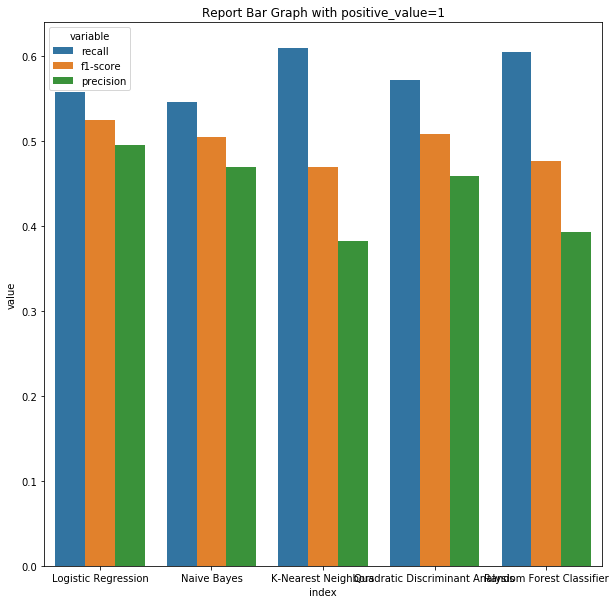

In [0]:
best_sampling_methods = []
for model_samplings in model_full_reports:
    current_max = 0
    current_max_index = -1
    for i in range(0, len(model_samplings)):
        if model_samplings[i]['1']['f1-score'] > current_max:
            current_max = model_samplings[i]['1']['f1-score']
            current_max_index = i
    if current_max_index == 0:
        print("Best 1 f1-score: None")
    if current_max_index == 1:
        print("Best 1 f1-score: Undersampling")
    if current_max_index == 2:
        print("Best 1 f1-score: SMOTE")
    best_sampling_methods.append(current_max_index)

best_model_sampling_methods = []
for i in range(0, len(model_full_reports)):    
    best_model_sampling_methods.append(model_full_reports[i][best_sampling_methods[i]])

bar_graph_report(list(model_dict.keys()),best_model_sampling_methods,positive_value='1')


In [0]:
''' This cell is used to produce the table seen in the 'Results' section of the report'''

model_reports_dfs = []
for report in best_model_sampling_methods:
  model_reports_dfs.append(pd.DataFrame(report)\
                              .transpose()\
                              .sort_index(axis=0).sort_index(axis=1)\
                              .drop(['macro avg','weighted avg'],axis=0)
                              .drop('support',axis=1))

merged_scores = pd.concat(model_reports_dfs).reset_index()
merged_scores

,index,bin count,f1-score,precision,recall
0,0,1795.000000,0.851820,0.867987,0.836308
1,1,605.000000,0.525140,0.495859,0.558553
2,accuracy,0.774167,0.774167,0.774167,0.774167
3,0,1775.400000,0.841933,0.862721,0.822193
4,1,624.600000,0.504947,0.469923,0.546125
5,accuracy,0.760417,0.760417,0.760417,0.760417
6,0,1543.000000,0.782925,0.864216,0.715728
7,1,857.000000,0.469581,0.382036,0.609857
8,accuracy,0.692000,0.692000,0.692000,0.692000
9,0,1729.400000,0.835022,0.867285,0.805116


## RFE Feature Selection on Logistic Regression

Given that Logistic Regression with undersampling performed best in our testing, we now use RFE to find the most optimal number of features for our final prediction, as well as what those features are. 

We iteratively perform RFE on the model and 10-fold cross validation on each subset of features produced. We identify that selecting 34 features resulted in the highest f1-score for defaulters, and hence we will be using these features for our final prediction. 

In [0]:
''' Initial features in the dataset '''

rfe_train = train_data.copy()
rfe_train = rfe_train.drop(paylate, axis=1)
rfe_X_train = rfe_train.drop('default payment next month', axis=1)
y_train = rfe_train[y_str]
print(rfe_X_train.columns)

sampler = RandomUnderSampler(random_state=0)
scaler = StandardScaler()
rfe_X_scaled_train = scaler.fit_transform(rfe_X_train)
rfe_X_undersampled_scaled_train, rfe_y_undersampled_train = sampler.fit_resample(rfe_X_train, y_train)


Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX 1', 'EDUCATION 1',
       'EDUCATION 2', 'EDUCATION 3', 'MARRIAGE 1', 'MARRIAGE 2',
       'PAY_LATE_MONTHS_1', 'PAY_DULY_1', 'PAY_LATE_MONTHS_2', 'PAY_DULY_2',
       'PAY_LATE_MONTHS_3', 'PAY_DULY_3', 'PAY_LATE_MONTHS_4', 'PAY_DULY_4',
       'PAY_LATE_MONTHS_5', 'PAY_DULY_5', 'PAY_LATE_MONTHS_6', 'PAY_DULY_6',
       'PAY_PERC_1', 'PAY_PERC_2', 'PAY_PERC_3', 'PAY_PERC_4', 'PAY_PERC_5',
       'CASH_FLOW_1', 'CASH_FLOW_2', 'CASH_FLOW_3', 'CASH_FLOW_4',
       'CASH_FLOW_5'],
      dtype='object')


In [0]:
''' Iteratively performing RFE with cross validation '''

rfe_results = []
for i in range(1,len(rfe_X_train.columns)):
    rfeLR = LogisticRegression()
    lr_rfe = RFE(rfeLR, i)
    lr_rfe.fit(rfe_X_undersampled_scaled_train, rfe_y_undersampled_train)
    
    lrRanking = lr_rfe.ranking_
    Xcols = rfe_X_train.columns.to_list()
    rfebestCols = []
    for index in range(len(lrRanking)):
        if lrRanking[index] == 1:
            rfebestCols.append(Xcols[index])
    
    print('N-SAMPLES='+str(i))    
    print(rfebestCols)
    rfe_results.append(k_fold_test(train_data, LogisticRegression(),y_str, X_features=rfebestCols, k=10, sampler=RandomUnderSampler(random_state=0)))


N-SAMPLES=1
['PAY_LATE_MONTHS_1']
              bin count  f1-score  precision    recall  support
0                1845.0  0.855446   0.859648  0.851345   1863.0
1                 555.0  0.508717   0.500742  0.517369    537.0
macro avg        2400.0  0.682081   0.680195  0.684357   2400.0
weighted avg     2400.0  0.777971   0.779501  0.776667   2400.0

accuracy:	0.7766666666666667
N-SAMPLES=2
['EDUCATION 3', 'PAY_LATE_MONTHS_1']
              bin count  f1-score  precision    recall  support
0                1845.0  0.855446   0.859648  0.851345   1863.0
1                 555.0  0.508717   0.500742  0.517369    537.0
macro avg        2400.0  0.682081   0.680195  0.684357   2400.0
weighted avg     2400.0  0.777971   0.779501  0.776667   2400.0

accuracy:	0.7766666666666667
N-SAMPLES=3
['EDUCATION 2', 'EDUCATION 3', 'PAY_LATE_MONTHS_1']
              bin count  f1-score  precision    recall  support
0                1845.0  0.855446   0.859648  0.851345   1863.0
1                 555.0  

Text(0, 0.5, 'score')

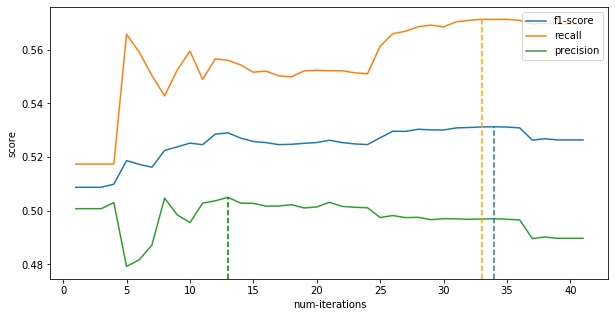

In [0]:
''' Finding the most optimal number of input features '''

full_rfe_results = pd.concat(map(pd.DataFrame.transpose,map(pd.DataFrame.from_dict,rfe_results)))
defaults_rfe_results = full_rfe_results.filter(like='1',axis=0)
defaults_rfe_results = defaults_rfe_results.reset_index()
defaults_rfe_results.index += 1


plt.figure(figsize=(10,5))
ax = plt.gca()

sns.lineplot(defaults_rfe_results.index,'f1-score',data=defaults_rfe_results)
sns.lineplot(defaults_rfe_results.index,'recall',data=defaults_rfe_results)
sns.lineplot(defaults_rfe_results.index,'precision',data=defaults_rfe_results)

y_max = ax.get_ylim()[1]
y_min = ax.get_ylim()[0]
f1_max = defaults_rfe_results['f1-score'].max()
recall_max = defaults_rfe_results['recall'].max()
precision_max = defaults_rfe_results['precision'].max()

plt.axvline(defaults_rfe_results['f1-score'].idxmax(), ymax=(f1_max-y_min)/(y_max-y_min), ls='--')
plt.axvline(defaults_rfe_results['recall'].idxmax(),ymax=(recall_max-y_min)/(y_max-y_min),ls='--',color='orange')
plt.axvline(defaults_rfe_results['precision'].idxmax(),ymax=(precision_max-y_min)/(y_max-y_min),ls='--',color='green')

ax.legend(['f1-score','recall','precision'],loc='upper right')
ax.set_xlabel('num-iterations')
ax.set_ylabel('score')

In [0]:
''' Overall feature rankings '''

rfeLR = LogisticRegression()
lr_rfe = RFE(rfeLR, 1)
lr_rfe.fit(rfe_X_undersampled_scaled_train, rfe_y_undersampled_train)

lrRanking = lr_rfe.ranking_
Xcols = rfe_X_train.columns.to_list()
ranking_col_pair = list(zip(Xcols,lrRanking))

sorted(ranking_col_pair, key=lambda x: x[1])

[('PAY_LATE_MONTHS_1', 1),
 ('EDUCATION 3', 2),
 ('EDUCATION 2', 3),
 ('EDUCATION 1', 4),
 ('PAY_LATE_MONTHS_5', 5),
 ('PAY_DULY_1', 6),
 ('PAY_DULY_2', 7),
 ('PAY_LATE_MONTHS_3', 8),
 ('PAY_DULY_6', 9),
 ('PAY_LATE_MONTHS_6', 10),
 ('SEX 1', 11),
 ('MARRIAGE 2', 12),
 ('MARRIAGE 1', 13),
 ('PAY_DULY_4', 14),
 ('PAY_PERC_3', 15),
 ('PAY_DULY_3', 16),
 ('PAY_PERC_5', 17),
 ('PAY_DULY_5', 18),
 ('PAY_PERC_4', 19),
 ('PAY_PERC_1', 20),
 ('PAY_LATE_MONTHS_4', 21),
 ('PAY_PERC_2', 22),
 ('PAY_LATE_MONTHS_2', 23),
 ('AGE', 24),
 ('PAY_AMT1', 25),
 ('PAY_AMT2', 26),
 ('PAY_AMT6', 27),
 ('PAY_AMT5', 28),
 ('PAY_AMT3', 29),
 ('CASH_FLOW_1', 30),
 ('BILL_AMT1', 31),
 ('PAY_AMT4', 32),
 ('CASH_FLOW_2', 33),
 ('BILL_AMT3', 34),
 ('BILL_AMT2', 35),
 ('CASH_FLOW_3', 36),
 ('LIMIT_BAL', 37),
 ('BILL_AMT6', 38),
 ('CASH_FLOW_4', 39),
 ('CASH_FLOW_5', 40),
 ('BILL_AMT5', 41),
 ('BILL_AMT4', 42)]

# 7. Final Predictions on Test Set

Finally, we use the RFE-selected features in the previous section to do prediction on the test set. Based on the testings above, we use Logistic Regression with random undersampling and standard scaling, resulting in the below classification report and confusion matrix.

We also presented a PCA scatterplot of our final prediction results, as to visualise the performance of our prediction model.


In [0]:
best_n_features_to_select = defaults_rfe_results['f1-score'].idxmax()

rfeLR = LogisticRegression()
lr_rfe = RFE(rfeLR, best_n_features_to_select)
lr_rfe.fit(rfe_X_undersampled_scaled_train, rfe_y_undersampled_train)

lrRanking = lr_rfe.ranking_
Xcols = rfe_X_train.columns.to_list()
rfebestCols = []
for index in range(len(lrRanking)):
    if lrRanking[index] == 1:
        rfebestCols.append(Xcols[index])

rfebestCols

['AGE',
 'BILL_AMT1',
 'BILL_AMT3',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX 1',
 'EDUCATION 1',
 'EDUCATION 2',
 'EDUCATION 3',
 'MARRIAGE 1',
 'MARRIAGE 2',
 'PAY_LATE_MONTHS_1',
 'PAY_DULY_1',
 'PAY_LATE_MONTHS_2',
 'PAY_DULY_2',
 'PAY_LATE_MONTHS_3',
 'PAY_DULY_3',
 'PAY_LATE_MONTHS_4',
 'PAY_DULY_4',
 'PAY_LATE_MONTHS_5',
 'PAY_DULY_5',
 'PAY_LATE_MONTHS_6',
 'PAY_DULY_6',
 'PAY_PERC_1',
 'PAY_PERC_2',
 'PAY_PERC_3',
 'PAY_PERC_4',
 'PAY_PERC_5',
 'CASH_FLOW_1',
 'CASH_FLOW_2']

In [0]:
lr = LogisticRegression()
scaler = StandardScaler()
sampler = RandomUnderSampler(random_state=0)

X_train = train_data[rfebestCols]
y_train = train_data[y_str]
X_test = test_data[rfebestCols]
y_test = test_data[y_str]

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

X_undersampled_scaled_train, y_undersampled_train = sampler.fit_resample(X_scaled_train, y_train)

lr.fit(X_undersampled_scaled_train,y_undersampled_train)

y_pred = lr.predict(X_scaled_test)

print('== CLASSIFICATION REPORT ==')
print(metrics.classification_report(y_test,y_pred))

print('\n== CONFUSION MATRIX ==')
print(metrics.confusion_matrix(y_test,y_pred))

== CLASSIFICATION REPORT ==
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      4734
           1       0.51      0.57      0.54      1266

    accuracy                           0.79      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.80      0.79      0.80      6000


== CONFUSION MATRIX ==
[[4035  699]
 [ 544  722]]


Text(0.5, 0, '')

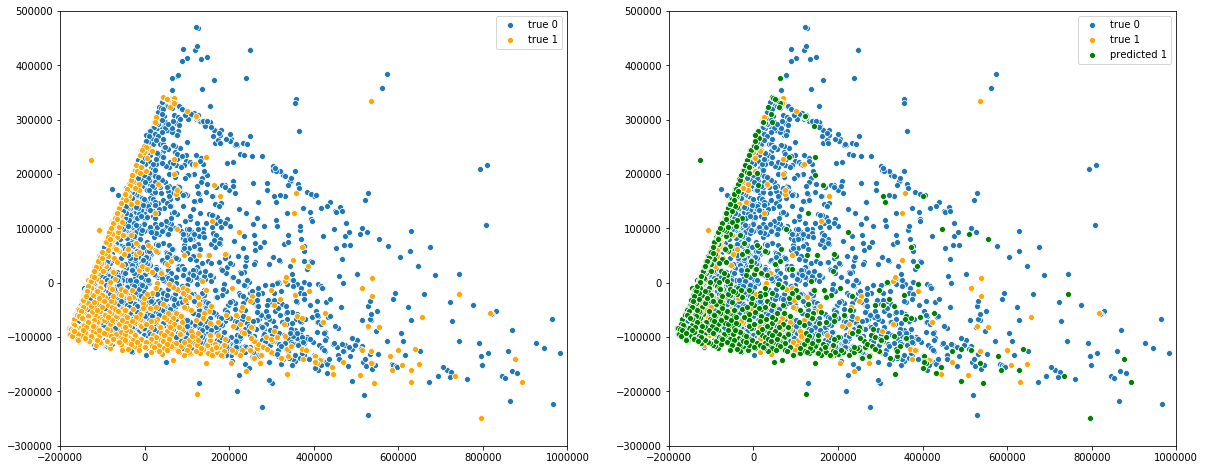

In [0]:
pca_test_data = test_data.copy()
pca_factor = PCA(n_components=2).fit_transform(pca_test_data[pay_amt+paylatemonths+['LIMIT_BAL']+bill_amt]).transpose()
pca_test_data['pca0'] = pca_factor[0]
pca_test_data['pca1'] = pca_factor[1]
fig,axs = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(20)


# sns.scatterplot(pca_test_data['pca0'],pca_test_data['pca1'],pca_test_data[y_str],size=5,edgecolors="black",legend=False,ax=axs[0])
sns.scatterplot(pca_test_data[pca_test_data[y_str]==0]['pca0'],pca_test_data[pca_test_data[y_str]==0]['pca1'],ax=axs[0])
sns.scatterplot(pca_test_data[pca_test_data[y_str]==1]['pca0'],pca_test_data[pca_test_data[y_str]==1]['pca1'],ax=axs[0],color="orange")

sns.scatterplot(pca_test_data[pca_test_data[y_str]==0]['pca0'],pca_test_data[pca_test_data[y_str]==0]['pca1'],ax=axs[1])
sns.scatterplot(pca_test_data[pca_test_data[y_str]==1]['pca0'],pca_test_data[pca_test_data[y_str]==1]['pca1'],ax=axs[1],color="orange")
sns.scatterplot(pca_test_data[y_pred==1]['pca0'],pca_test_data[y_pred==1]['pca1'],ax=axs[1],color="green")


axs[0].set_xlim([-200000,1000000])
axs[0].set_ylim([-300000,500000])
axs[0].legend(['true 0','true 1'])
axs[0].set_ylabel('')    
axs[0].set_xlabel('')

axs[1].set_xlim([-200000,1000000])
axs[1].set_ylim([-300000,500000])
axs[1].legend(['true 0','true 1','predicted 1'])
axs[1].set_ylabel('')    
axs[1].set_xlabel('')